# Análise de Conversas em Grupo no Whatsapp
###### Desenvolvido por: Johannes Sesselmann

<p style = 'background-color:gray; color:white'> Parte 1:</p>

Primeiramente, vamos importar as bibliotecas a serem utilizadas no projeto e criar as funções iniciais.

In [2]:
import regex
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [3]:
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

<p style = 'background-color:gray; color:white'> Parte 2</p>

Inicialmente, salvei a conversa num txt utilizando as próprias funções do Whats App.

In [144]:
data = []
conversation = 'Conversa no WhatsApp com psicoticodata.txt'

with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

dados = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
dados['Date'] = pd.to_datetime(dados['Date'])
print(dados.head(20))
print(dados.info())
print(dados.Author.unique())

Eventualmente, precisamos transformar esse txt em um dataframe para futuras análises.

In [146]:
indice = []
contador = 0;
for i in dados['Message']:
    if i == '<Ficheiro não revelado>':
        indice.append(contador)
    contador += 1

In [147]:
df = dados.drop(labels = indice)

In [148]:
df

,Date,Time,Author,Message
0,2021-08-10,01:02,Johannes Sesselmann,KKKKKK
1,2021-08-10,01:02,Johannes Sesselmann,Eu vou tentar dar migue
2,2021-08-10,01:02,Gaza,Essa resposta aqui foi muito boa
3,2021-08-10,01:02,Johannes Sesselmann,Preciso de fazer essa prova
4,2021-08-10,01:02,Raphael Hailer,e isso pq eles respeitam o aluno!
...,...,...,...,...
39992,2022-01-06,22:54,Johannes Sesselmann,sim kkkkkkk
39993,2022-01-06,23:04,Paulo Kuga,nao
39994,2022-01-06,23:04,Paulo Kuga,eu vi isso tbm
39995,2022-01-06,23:04,Paulo Kuga,se o unicamper frequentador do spotted ri da p...


In [149]:
total_messages = df.shape[0]
print(total_messages)

36959


Nessa parte do projeto, eu tentei interpretar os emojis, mas com a atualização do whats app parece que o programa não está mais identificando emojis, uma pena:

In [150]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list
df['emoji'] = df["Message"].apply(split_count)

emojis = sum(df['emoji'].str.len())
print(emojis)

0


In [151]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Mensagens trocadas:", total_messages)
print("Número de emojis trocados:", emojis)
print("Número de links trocados:", links)

Mensagens trocadas: 36959
Número de emojis trocados: 0
Número de links trocados: 266


<p style = 'background-color:gray; color:white'> Parte 3</p>

A partir de agora, vou tentar pegar todas as stopwords em português e tirar elas do meu compilado. Qual o motivo? Bom, eu quero fazer uma nuvem de palavras limpa, se eu deixar as stopwords, só vai aparecer coisas do tipo 'eu', 'você', 'faz', o que não é muito útil para o meu objetivo!

In [152]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)

In [153]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [154]:
stopwords1 = stopwords.words('portuguese')

As stopwords do NTLK não são suficientes para minha nuvem de palavra ficar bonita! Tive que tirar risadas e os nomes dos integrantes do grupo e afins.

In [155]:
more_words = ['b', 'n', 'kkkkkkk', 'kkkkkkkk', 'kkkkkkkkk', 'KKKKK', 'kkkk', 'KKK', 'KKKKKKKKKKKKK', 'Johanne', 'Luiz', 'Dudu', 'Gu', 'B', 'Johannes',
             'KKKKKKKKKKKK', 'KKKKKKKKKK', 'KKKKKK', 'KKKKKKKKKKK', 'kkkkkkkkkkk', 'q', 'vc' , 'vai' , 'mano', 'pra', 'nao' , 'fazer', 'tipo'
             , 'sim' , 'pq' , 'cara','tá' , 'assim', 'bem', 'acho', 'ai', 'p', 'sei', 'coisa', 'eh', 'pessoa', 'to', 'mt' ,'grupo', 'tava', 'vou',
              'ah' , 'c' , 'tb', 'ta' , 'ce'
             ]

for i in more_words:
    stopwords1.append(i)

In [156]:
print(stopwords1)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

<p style = 'background-color:gray; color:white'> Parte 4</p>

Agora, eu retiro as stopwords do meu texto original e, assim, consigo fazer uma nuvem de palavras mais interessante:

There are 1280324 words in all the messages.


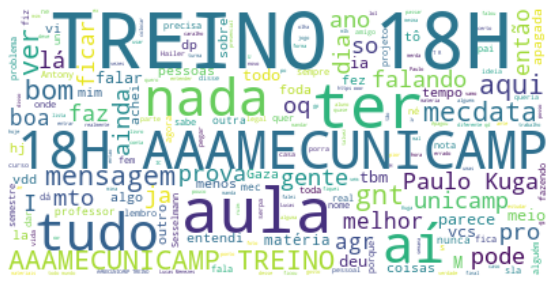

In [158]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords1, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Bacana, né? Eu pelo menos gostei muito.